# 프로젝트 소개

### 프로젝트 요약 

- 자율주행의 핵심 기술중 하나인 표지판 인식 기능의 성능이 흑백이미지와 컬러이미지에서 차이를 보이는지 분석.

- 자율 주행시스템의 판단은 사람의 목숨과 직결되기 때문에 빠를수록, 정확할수록 좋다. 그리고, 제조과정에서의 원가절감은 언제나 환영이다. 이 프로젝트는 컬러/흑백 이미지를 사용할 때의 모델의 정확도, 학습/예측 속도를 비교/분석한 결과와 컬러/흑백 카메라의 가격, 해상도를 조사한 결과를 바탕으로 흑백 카메라를 사용하는 것이 좋다는 것을 주장하기 위한 것이다.

### 프로젝트 배경 지식

1. 자율주행 자동차에는 여러대의 카메라가 필수적으로 설치된다(ex. Waymo: 29개, Tesla: 9개). 그리고, 흑백 카메라는 컬러 카메라보다 저렴하다(약 10%). 즉, 흑백 이미지를 사용했을 때와 컬러 이미지를 사용했을 때의 표지판 인식 정확도에 차이가 없다면 흑백 카메라를 설치하는 것이 원가절감에 도움이 될 것이다.

2. 같은 화소수를 가진 컬러/흑백 카메라를 사용할 경우, 컬러 카메라로 촬영한 이미지의 해상도가 흑백 이미지의 ⅓ 이기때문에, 흑백 카메라를 사용하는 것이 유리하다. (컬러 카메라는 흑백 카메라의 센서 위에 Bayer 필터(RGB 필터)를 부착한 것이기 때문에, 색깔별로 화소수를 나눠가진다. 즉, 컬러 카메라는 Bayer 필터를 추가적으로 부착해야하기 때문에 더 비싸고 이미지의 해상도는 낮음)

3. 컬러 이미지는 채널이 3개로(RGB) 흑백 이미지보다 데이터 사이즈가 3배 크기 때문에 더 큰 저장 공간을 필요로 한다. 또한, 큰 데이터 사이즈 때문에 컬러 이미지를 처리하는 속도가 흑백 이미지를 처리하는 속도보다 느리기 때문에 자율주행 판단을 지연시킬 수 있다. 

4. 컴퓨터를 사용한 이미지 처리에서는 흑백 이미지가 컬러 이미지보다 더 선호된다. 색깔은 인간에겐 많은 정보를 주지만, 컴퓨터는 흑백 정보만으로도 이미지의 패턴, 윤곽, 모양 등의 속성을 충분히 파악할 수 있다고 한다. 

### 가설 
 
- 딥러닝 모델은 컬러 이미지를 사용했을 때의 학습/예측 시간이 흑백 이미지를 사용할 때보다 오래걸리고, 정확도에선 큰 차이를 보이지 않을 것이다. 


### 진행 순서

1. 이미지 인식을 위한 모델들(머신러닝 : Random forest, 딥러닝 : CNN)을 만들고, 컬러 이미지를 가지고 모델의 성능(정확도, 학습/예측 시간)을 측정한다. 

    (머신러닝과 딥러닝 모델을 둘 다 사용해본 이유는 단순히 CNN모델이 이미지 분석에 더 효율적이라는 것을 보기 위함이다. 자세히 봐야할 것은 컬러 이미지와 흑백 이미지의 결과 비교이다.)

2. 흑백 이미지를 가지고 같은 학습/테스트를 진행한다.

3. 가설 검증 : 1번과 2번의 결과를 비교한다. 이때, 학습/예측 속도와 정확도를 모두 비교한다.

4. 가설 검증을 완료하고 모델의 성능을 개선해본다. 개선표지판 인식에 좋은 정확도와 처리속도를 보이는 모델을 만들기 위해 CNN 모델을 개선시키는 방법들 (EfficientNet 논문에 소개된 Width Scaling, Depth Scaling, Resolution Scaling, Compound Scaling)을 적용해 본다.

5. Data Augmentation 을 통해 훈련 데이터셋을 늘려 학습을 진행한다.

6. CV(Cross Validation) 를 사용해서 데이터 편중과 과적합을 막고 일반화된 모델 얻는다.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
import cv2
import random
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tensorflow import keras

In [ ]:
!unzip /content/drive/MyDrive/dataset/archive.zip

# 데이터 전처리

### Train, Test 불러오기 (이미지/레이블)

In [ ]:
### train 데이터 불러오기 ###

train_images_high = []
train_images_low = []
train_labels =[]
classes = 43
current_path = os.getcwd()

# 이미지와 레이블 불러오기
for i in range(classes):
    path = os.path.join(current_path, 'Train', str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '/' + a)
            image_high = np.array(image.resize((54,54)))
            image_low = np.array(image.resize((18,18)))
            train_images_high.append(image_high)
            train_images_low.append(image_low)
            train_labels.append(i)
        except:
            print("Error loading image")


train_images_high = np.array(train_images_high)
train_images_low = np.array(train_images_low)
train_labels = np.array(train_labels)

In [ ]:
### 테스트 데이터셋 불러오기 ###

test_data = pd.read_csv('Test.csv')

test_labels = test_data["ClassId"].values
imgs = test_data["Path"].values

test_images_high=[]
test_images_low=[]

for img in imgs:
    image = Image.open(img)
    image_high = image.resize((54,54))
    image_low = image.resize((18,18))
    test_images_high.append(np.array(image_high))
    test_images_low.append(np.array(image_low))


test_images_high=np.array(test_images_high)
test_images_low=np.array(test_images_low)

In [ ]:
# train과 test데이터 셋의 이미지/레이블 shape
print("Train(high) : ", train_images_high.shape, train_labels.shape)
print("Train(low)  : ", train_images_low.shape, train_labels.shape)
print("Test(high)  : ", test_images_high.shape, test_labels.shape)
print("Test(low)   : ", test_images_low.shape, test_labels.shape)

Train(high) :  (39209, 54, 54, 3) (39209,)
Train(low)  :  (39209, 18, 18, 3) (39209,)
Test(high)  :  (12630, 54, 54, 3) (12630,)
Test(low)   :  (12630, 18, 18, 3) (12630,)


### 컬러 이미지 해상도 비교

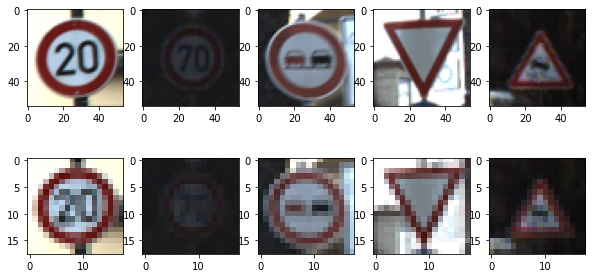

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(10,5))
ax[0,0].imshow(train_images_high[0].squeeze(), cmap='gray')
ax[0,1].imshow(train_images_high[7000].squeeze(), cmap='gray')
ax[0,2].imshow(train_images_high[14000].squeeze(), cmap='gray')
ax[0,3].imshow(train_images_high[21000].squeeze(), cmap='gray')
ax[0,4].imshow(train_images_high[28000].squeeze(), cmap='gray')
ax[1,0].imshow(train_images_low[0].squeeze(), cmap='gray')
ax[1,1].imshow(train_images_low[7000].squeeze(), cmap='gray')
ax[1,2].imshow(train_images_low[14000].squeeze(), cmap='gray')
ax[1,3].imshow(train_images_low[21000].squeeze(), cmap='gray')
ax[1,4].imshow(train_images_low[28000].squeeze(), cmap='gray')


### 흑백 이미지 준비

In [ ]:
# 컬러이미지를 흑백으로 바꿔주기

train_images_gray = []
for i in range(train_images_high.shape[0]):
    gray_image = cv2.cvtColor(train_images_high[i], cv2.COLOR_BGR2GRAY).reshape((54, 54, 1))
    train_images_gray.append(gray_image)

test_images_gray = []
for i in range(test_images_high.shape[0]):
    gray_image = cv2.cvtColor(test_images_high[i], cv2.COLOR_BGR2GRAY).reshape((54, 54, 1))
    test_images_gray.append(gray_image)
    
train_images_gray = np.array(train_images_gray)
test_images_gray = np.array(test_images_gray)

In [ ]:
# train과 test데이터 셋의 이미지/레이블 shape (흑백 이미지)
print("Train : ", train_images_gray.shape, train_labels.shape)
print("Test  : ", test_images_gray.shape, test_labels.shape)

Train :  (39209, 54, 54, 1) (39209,)
Test  :  (12630, 54, 54, 1) (12630,)


### 이미지 데이터 정규화, 데이터 크기 차이 보기

In [ ]:
# 이미지 데이터 정규화

# 컬러 고화질
train_images_high = train_images_high / 255.
test_images_high = test_images_high / 255.

# 컬러 저화질
train_images_low = train_images_low / 255.
test_images_low = test_images_low / 255.

# 흑백 고화질
train_images_gray = train_images_gray / 255.
test_images_gray = test_images_gray / 255.

In [ ]:
# 컬러 이미지와 흑백 이미지의 데이터 크기 차이 (3배)
print("컬러 이미지 데이터 사이즈 (높은 해상도) : ", sys.getsizeof(train_images_high))
print()
print("흑백 이미지 데이터 사이즈 (높은 해상도) : ", sys.getsizeof(train_images_gray))

컬러 이미지 데이터 사이즈 (높은 해상도) :  2744002800

흑백 이미지 데이터 사이즈 (높은 해상도) :  914667696


# 컬러 이미지 머신러닝

In [ ]:
# 이미지 flatten

train_images_flat = train_images_high.flatten().reshape(39209, 8748)
test_images_flat = test_images_high.flatten().reshape(12630, 8748)

In [ ]:
# flatten 된 이미지 데이터 셋 shape

print("1차원 train 데이터셋 shape : ", train_images_flat.shape)
print("1차원 test 데이터셋 shape  : ", test_images_flat.shape)

1차원 train 데이터셋 shape :  (39209, 8748)
1차원 test 데이터셋 shape  :  (12630, 8748)


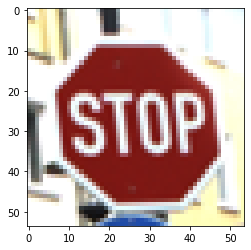

레이블 =  14


In [ ]:
# 납작해진 데이터를 다시 컬러 이미지로 살려서 보기

test_img = train_images_flat[23000].reshape(54, 54, 3)
test_target = train_labels[23000]

plt.imshow(test_img)
plt.show()

print("레이블 = ",test_target)

In [ ]:
# 데이터 셋 나누기

X_val_color_flat, X_test_color_flat, y_val, y_test = train_test_split(test_images_flat, test_labels, test_size=0.5, random_state=777)
print("학습 데이터 shape : ", train_images_flat.shape, train_labels.shape)
print("검증 데이터 shape : ", X_val_color_flat.shape, y_val.shape)
print("테스트 데이터 shape : ", X_test_color_flat.shape, y_test.shape)

학습 데이터 shape :  (39209, 8748) (39209,)
검증 데이터 shape :  (6315, 8748) (6315,)
테스트 데이터 shape :  (6315, 8748) (6315,)


In [ ]:
# RandomForestClassifier 학습

clf = RandomForestClassifier()
%time clf.fit(train_images_flat, train_labels)

CPU times: user 5min 9s, sys: 311 ms, total: 5min 10s
Wall time: 5min 10s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# validation, test 데이터 셋으로 예측해보고 정확도 보기
pred_val = clf.predict(X_val_color_flat)
%time pred_test = clf.predict(X_test_color_flat)

print("validation 예측 정확도 : ",accuracy_score(y_val, pred_val))
print("test 예측 정확도 : ",accuracy_score(y_test, pred_test))

CPU times: user 503 ms, sys: 8 ms, total: 511 ms
Wall time: 511 ms
validation 예측 정확도 :  0.7960411718131433
test 예측 정확도 :  0.7893903404592241


<Figure size 432x288 with 0 Axes>

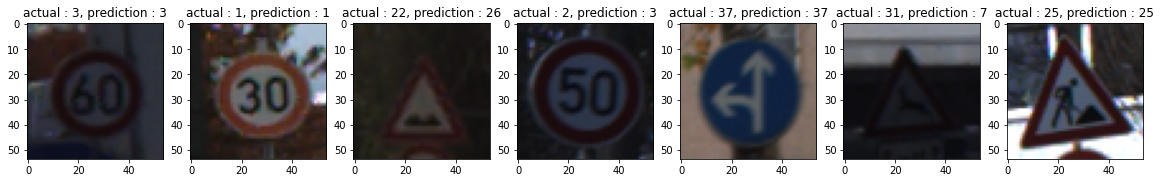

In [ ]:
# test셋 이미지의 실제 label과 예측결과 확인

fig = plt.figure()
random_pick = np.random.randint(0, y_test.shape[0], 7)

fig, ax = plt.subplots(1, 7, figsize=(20,5))

for i in range(7):
    idx = random_pick[i]
    img = np.reshape(X_test_color_flat[idx], (54, 54, 3))
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title('actual : ' + str(y_test[random_pick[i]]) + ', prediction : ' + str(pred_test[idx]))

# 흑백 이미지 머신러닝

In [ ]:
# 흑백 이미지 flatten

train_images_gray_flat = train_images_gray.flatten().reshape(39209, 2916)
test_images_gray_flat = test_images_gray.flatten().reshape(12630, 2916)

In [ ]:
# flatten 된 흑백 이미지 데이터 셋 shape

print("1차원 train 데이터셋 shape : ", train_images_gray_flat.shape)
print("1차원 test 데이터셋 shape  : ", test_images_gray_flat.shape)

1차원 train 데이터셋 shape :  (39209, 2916)
1차원 test 데이터셋 shape  :  (12630, 2916)


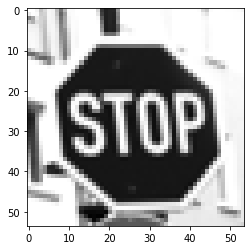

레이블 =  14


In [ ]:
# 납작해진 데이터를 다시 컬러 이미지로 살려서 보기

test_img = train_images_gray_flat[23000].reshape(54, 54, 1)
test_target = train_labels[23000]

plt.imshow(test_img.squeeze(), cmap='gray')
plt.show()

print("레이블 = ",test_target)

In [ ]:
# 데이터 셋 나누기

X_val_gray_flat, X_test_gray_flat, y_val, y_test = train_test_split(test_images_gray_flat, test_labels, test_size=0.5, random_state=777)
print("학습 데이터 shape : ", train_images_gray_flat.shape, train_labels.shape)
print("검증 데이터 shape : ", X_val_gray_flat.shape, y_val.shape)
print("테스트 데이터 shape : ", X_test_gray_flat.shape, y_test.shape)

학습 데이터 shape :  (39209, 2916) (39209,)
검증 데이터 shape :  (6315, 2916) (6315,)
테스트 데이터 shape :  (6315, 2916) (6315,)


In [ ]:
# RandomForestClassifier 학습

clf2 = RandomForestClassifier()
%time clf2.fit(train_images_gray_flat, train_labels)

CPU times: user 2min 55s, sys: 203 ms, total: 2min 56s
Wall time: 2min 56s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# validation, test 데이터 셋으로 예측해보고 정확도 보기
pred_val_gray = clf2.predict(X_val_gray_flat)
%time pred_test_gray = clf2.predict(X_test_gray_flat)

print("validation 예측 정확도 : ",accuracy_score(y_val, pred_val_gray))
print("test 예측 정확도 : ",accuracy_score(y_test, pred_test_gray))

CPU times: user 400 ms, sys: 2 ms, total: 402 ms
Wall time: 402 ms
validation 예측 정확도 :  0.7838479809976246
test 예측 정확도 :  0.7851148060174189


<Figure size 432x288 with 0 Axes>

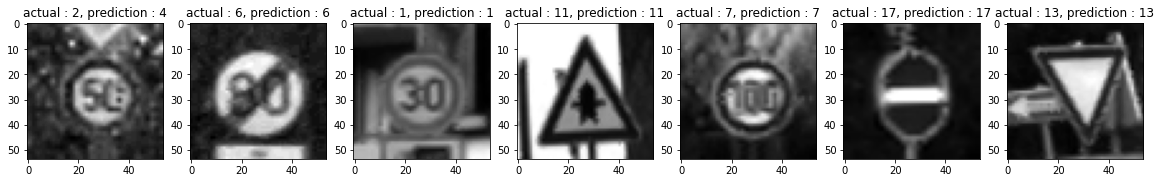

In [ ]:
# test셋 이미지의 실제 label과 예측결과 확인

fig = plt.figure()
random_pick = np.random.randint(0, y_test.shape[0], 7)

fig, ax = plt.subplots(1, 7, figsize=(20,5))

for i in range(7):
    idx = random_pick[i]
    img = np.reshape(X_test_gray_flat[idx], (54, 54, 1))
    ax[i].imshow(img.squeeze(), cmap='gray')
    ax[i].set_title('actual : ' + str(y_test[random_pick[i]]) + ', prediction : ' + str(pred_test_gray[idx]))

## 컬러 이미지/흑백 이미지 머신러닝 결과 비교

**컬러 이미지**

    학습 속도 : CPU times: 5min 10s, Wall time: 5min 10s
    예측 속도 : CPU times: 551 ms, Wall time: 551 ms
    validation 예측 정확도 :  0.7960
    test 예측 정확도 :  0.7894

**흑백 이미지**

    학습 속도 : CPU times: 2min 56s, Wall time: 2min 56s
    예측 속도 : CPU times: 402 ms, Wall time: 402 ms
    validation 예측 정확도 :  0.7838
    test 예측 정확도 :  0.7851


1. 머신러닝 모델(Random Forest)을 사용한 표지판 이미지 분류 성능은 80% 가 넘지않는다. 
2. 학습 속도와 예측 속도는 흑백 이미지를 사용했을 때가 훨씬 빠르다. (5min 10s => 2min 56s, 551 ms => 402 ms)
3. 정확도는 크게 차이나지 않는다.

아래에선 간단한 이미지 처리에 좋은 성능을 보이는 딥러닝 모델(CNN)을 통해 컬러/흑백 이미지의 결과를 비교/분석 해보겠습니다. 그 후, 비교적 좋은 결과를 보이는 모델을 개선시켜 보겠습니다.

# 컬러 이미지 딥러닝

In [ ]:
# 데이터 셋 나누기
X_train_color = train_images_high
X_val_color, X_test_color, y_val_color, y_test_color = train_test_split(test_images_high, test_labels, test_size=0.5, random_state=7)

# 레이블 원 핫 인코딩
y_train_color = to_categorical(train_labels, 43)
y_val_color = to_categorical(y_val_color, 43)

print("훈련 셋 : ", X_train_color.shape, y_train_color.shape)
print("검증 셋 : ", X_val_color.shape, y_val_color.shape)
print("테스트 셋 : ", X_test_color.shape, y_test_color.shape)

훈련 셋 :  (39209, 54, 54, 3) (39209, 43)
검증 셋 :  (6315, 54, 54, 3) (6315, 43)
테스트 셋 :  (6315, 54, 54, 3) (6315,)


In [ ]:
# 모델 만들기
model_1 = Sequential()
model_1.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=X_train_color.shape[1:]))
model_1.add(MaxPool2D(pool_size=(2, 2)))
model_1.add(Dropout(rate=0.25))
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_1.add(MaxPool2D(pool_size=(2, 2)))
model_1.add(Dropout(rate=0.25))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(rate=0.5))
model_1.add(Dense(43, activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 52, 52, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [ ]:
# 모델 학습
%time history_1 = model_1.fit(X_train_color, y_train_color, batch_size=32, epochs=15, validation_data=(X_val_color, y_val_color))

Epoch 1/15
1226/1226 [==============================] - 20s 4ms/step - loss: 2.2879 - accuracy: 0.3736 - val_loss: 0.5824 - val_accuracy: 0.8459
Epoch 2/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.5981 - accuracy: 0.8144 - val_loss: 0.3630 - val_accuracy: 0.9040
Epoch 3/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.3745 - accuracy: 0.8814 - val_loss: 0.3186 - val_accuracy: 0.9156
Epoch 4/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.2980 - accuracy: 0.9064 - val_loss: 0.2598 - val_accuracy: 0.9215
Epoch 5/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.2397 - accuracy: 0.9238 - val_loss: 0.2421 - val_accuracy: 0.9308
Epoch 6/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.2091 - accuracy: 0.9341 - val_loss: 0.2036 - val_accuracy: 0.9405
Epoch 7/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.1823 - accuracy: 0.9413 - val_loss: 0.2244 - val_accuracy

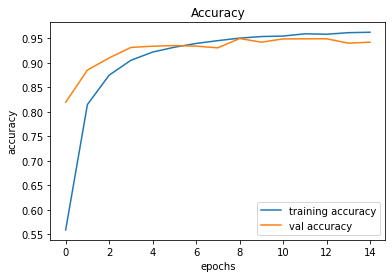

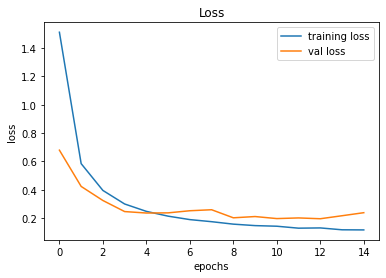

In [ ]:
# 모델의 정확도와 loss 변화
plt.figure(0)
plt.plot(history_1.history['accuracy'], label='training accuracy')
plt.plot(history_1.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history_1.history['loss'], label='training loss')
plt.plot(history_1.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 테스트셋(컬러) 정확도
%time pred_test = model_1.predict_classes(X_test_color)
print(accuracy_score(y_test_color, pred_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CPU times: user 507 ms, sys: 83.8 ms, total: 591 ms
Wall time: 419 ms
0.9521773555027712


# 흑백 이미지 딥러닝

In [ ]:
# 데이터 셋 나누기
X_train_gray = train_images_gray
X_val_gray, X_test_gray, y_val_gray, y_test_gray = train_test_split(test_images_gray, test_labels, test_size=0.5, random_state=7)

# 레이블 원 핫 인코딩
y_train_gray = to_categorical(train_labels, 43)
y_val_gray = to_categorical(y_val_gray, 43)

print("학습 셋 : ", X_train_gray.shape, y_train_gray.shape)
print("검증 셋 : ", X_val_gray.shape, y_val_gray.shape)
print("테스트 셋 : ", X_test_gray.shape, y_test_gray.shape)

학습 셋 :  (39209, 54, 54, 1) (39209, 43)
검증 셋 :  (6315, 54, 54, 1) (6315, 43)
테스트 셋 :  (6315, 54, 54, 1) (6315,)


In [ ]:
# 모델 만들기
model_2 = Sequential()
model_2.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=X_train_gray.shape[1:]))
model_2.add(MaxPool2D(pool_size=(2, 2)))
model_2.add(Dropout(rate=0.25))
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPool2D(pool_size=(2, 2)))
model_2.add(Dropout(rate=0.25))
model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(rate=0.5))
model_2.add(Dense(43, activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 52, 52, 8)         80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 8)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [ ]:
# 모델 학습
%time history_2 = model_2.fit(X_train_gray, y_train_gray, batch_size=32, epochs=15, validation_data=(X_val_gray, y_val_gray))

Epoch 1/15
1226/1226 [==============================] - 5s 3ms/step - loss: 2.4134 - accuracy: 0.3540 - val_loss: 0.7417 - val_accuracy: 0.8033
Epoch 2/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.6950 - accuracy: 0.7845 - val_loss: 0.4954 - val_accuracy: 0.8744
Epoch 3/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.4531 - accuracy: 0.8596 - val_loss: 0.3800 - val_accuracy: 0.9036
Epoch 4/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.3448 - accuracy: 0.8933 - val_loss: 0.3346 - val_accuracy: 0.9216
Epoch 5/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.2969 - accuracy: 0.9065 - val_loss: 0.2954 - val_accuracy: 0.9260
Epoch 6/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.2455 - accuracy: 0.9246 - val_loss: 0.2888 - val_accuracy: 0.9327
Epoch 7/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.2144 - accuracy: 0.9335 - val_loss: 0.2750 - val_accuracy:

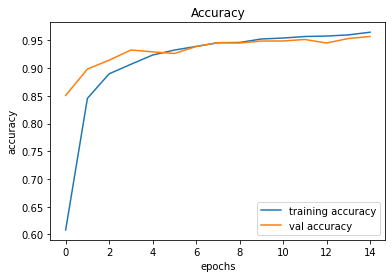

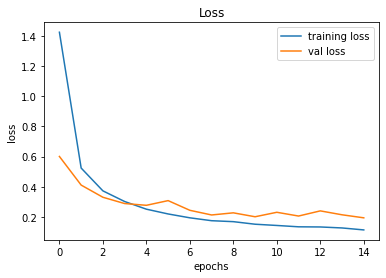

In [ ]:
# 모델의 정확도와 loss 변화 
plt.figure(0)
plt.plot(history_2.history['accuracy'], label='training accuracy')
plt.plot(history_2.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history_2.history['loss'], label='training loss')
plt.plot(history_2.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 테스트셋(흑백) 정확도
%time pred_test_gray = model_2.predict_classes(X_test_gray)
print(accuracy_score(y_test_gray, pred_test_gray))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CPU times: user 405 ms, sys: 39 ms, total: 444 ms
Wall time: 303 ms
0.9518606492478227


## 컬러 이미지/흑백 이미지 딥러닝 결과 비교

**컬러 이미지**

    학습 시간 : CPU times: 1min 41s, Wall time: 1min 20s 
    예측 시간 : CPU times: 591 ms, Wall time: 419 ms
    validation 예측 정확도 :  0.9474
    test 예측 정확도 :  0.9521

**흑백 이미지**

    학습 시간 : CPU times: 1min 33s, Wall time: 1min 1s
    예측 시간 : CPU times: 444 ms, Wall time: 303 ms
    validation 예측 정확도 :  0.9473
    test 예측 정확도 :  0.9519


=> 정확도 측면에서 거의 차이가 안난다. 하지만 훈련과 예측시간 측면에선 컬러이미지가 약 20~30% 정도 더 시간이 걸린다.

## Grad_CAM

Grad_CAM 은 CNN 모델이 의사결정을 할 때 이미지의 어떤 특징들을 보고 그런 결정을 내렸는지를 보여주는 도구입니다. 여기선, 컬러 이미지를 통해 학습한 모델과 흑백 이미지를 통해 학습한 모델이 각 이미지(컬러, 흑백)의 특징을 비슷하게 파악하고 있는지, 아니면 각자 전혀 다르게 이미지를 파악 하는지를 확인해 보겠습니다.

In [ ]:
# 히트맵을 만들기위한 함수 1
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
# 히트맵을 만들기위한 함수 2
def make_heatmap(img, model, last_conv):
    img_array = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])

    preds = model.predict(img_array)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv)

    return heatmap

In [ ]:
# grad-cam 생성 함수
def grad_cam(img, heatmap):
    img = X_test_color[0]
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = array_to_img(superimposed_img)

    return superimposed_img

In [ ]:
# grad-cam 결과를 볼 이미지
grad_img_color = X_test_color[2021]
grad_img_gray = X_test_gray[2021]

# 모델들의 마지막 conv 층
model_1_last_conv = model_1.layers[3].name
model_2_last_conv = model_2.layers[3].name

# 히트맵 생성
headtmap_color = make_heatmap(grad_img_color, model_1, model_1_last_conv)
headtmap_gray = make_heatmap(grad_img_gray, model_2, model_2_last_conv)

# grad-cam 생성
grad_cam_color = grad_cam(grad_img_color, headtmap_color)
grad_cam_gray = grad_cam(grad_img_gray, headtmap_gray)

Text(0.5, 1.0, 'gray image Grad-CAM')

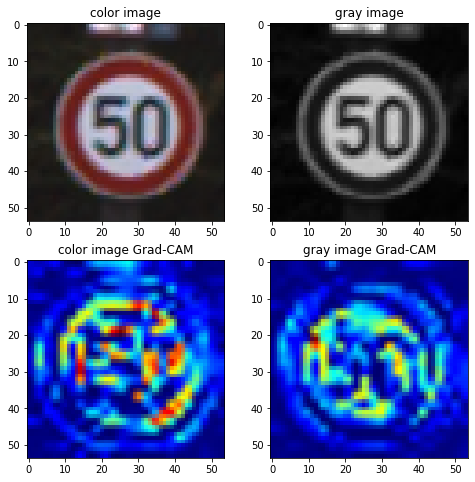

In [ ]:
# grad-cam 시각화
fig, ax = plt.subplots(2, 2, figsize=(8,8))
ax[0,0].imshow(grad_img_color)
ax[0,0].set_title("color image")
ax[0,1].imshow(grad_img_gray.squeeze(), cmap="gray")
ax[0,1].set_title("gray image")
ax[1,0].imshow(grad_cam_color)
ax[1,0].set_title("color image Grad-CAM")
ax[1,1].imshow(grad_cam_gray)
ax[1,1].set_title("gray image Grad-CAM")

두 모델은 이미지의 특징들을 비슷하게 파악하는 것으로 보인다. 왼쪽이 컬러 이미지를 통해 학습한 모델이고, 오른쪽이 흑백 이미지를 통해 학습한 모델이다. 두 모델 모두 표지판의 모양과 표지판에 쓰여진 글자 정보를 잘 구별하고있다.

# 해상도에 대한 배경 지식

위에서 비교한 컬러/흑백 이미지는 같은 해상도를 가집니다. 그렇다면, 두 이미지가 같은 화소수를 가진 컬러/흑백 카메라로 촬영된 것일까요? 그렇지 않습니다.  

<p align='center'>
<img width="400" alt="스크린샷 2021-03-09 오후 10 16 11" src="https://user-images.githubusercontent.com/61172021/110476224-14f05580-8125-11eb-851f-52a576540171.png">
</p>

같은 화소수를 가진 컬러/흑백 카메라로 촬영을 할 경우, 컬러 카메라로 찍은 이미지의 해상도는 흑백 카메라로 찍은 이미지의 해상도의 1/3 밖에 되지않습니다. 그 이유는, 컬러 카메라의 구조를 살펴보면 알기 쉽습니다. 위 그림처럼, 컬러 카메라는 흑백 카메라의 센서에 Bayer 필터(=RGB 필터)를 부착해 만들어 지는데, 이 필터는 빨간색, 파란색, 초록색에 해당되는 색깔 정보를 위해 화소를 나눠 갖습니다. 그렇기때문에 카메라의 화소를 100% 사용해 이미지를 표현할 수 있는 흑백 카메라가 해상도가 3배 높습니다. 

그렇다면, 비교를 하기위한 컬러 이미지와 흑백 이미지의 해상도에 차이를 둬야합니다. 아래에선, 같은 화소수의 카메라를 썼다는 가정하에 컬러 이미지의 해상도를 낮추고, 위에서 진행한 분석을 똑같이 해보겠습니다.

# 컬러 이미지 딥러닝 (낮은 해상도)

In [ ]:
# 데이터 셋 나누기
X_train_color_low = train_images_low
X_val_color_low, X_test_color_low, y_val_low, y_test_low = train_test_split(test_images_low, test_labels, test_size=0.5, random_state=7)

# 레이블 원 핫 인코딩
y_train_low = to_categorical(train_labels, 43)
y_val_low = to_categorical(y_val_low, 43)

print("훈련 셋 : ", X_train_color_low.shape, y_train_low.shape)
print("검증 셋 : ", X_val_color_low.shape, y_val_low.shape)
print("테스트 셋 : ", X_test_color_low.shape, y_test_low.shape)

훈련 셋 :  (39209, 18, 18, 3) (39209, 43)
검증 셋 :  (6315, 18, 18, 3) (6315, 43)
테스트 셋 :  (6315, 18, 18, 3) (6315,)


In [ ]:
# 모델 만들기
model_3 = Sequential()
model_3.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=X_train_color_low.shape[1:]))
model_3.add(MaxPool2D(pool_size=(2, 2)))
model_3.add(Dropout(rate=0.25))
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_3.add(MaxPool2D(pool_size=(2, 2)))
model_3.add(Dropout(rate=0.25))
model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(rate=0.5))
model_3.add(Dense(43, activation='softmax'))
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 8)         224       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 16)          1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)              

In [ ]:
# 모델 학습
history_3 = model_3.fit(X_train_color_low, y_train_low, batch_size=32, epochs=15, validation_data=(X_val_color_low, y_val_low))

Epoch 1/15
1226/1226 [==============================] - 5s 4ms/step - loss: 3.0469 - accuracy: 0.1830 - val_loss: 1.4677 - val_accuracy: 0.5417
Epoch 2/15
1226/1226 [==============================] - 5s 4ms/step - loss: 1.5610 - accuracy: 0.5135 - val_loss: 1.0331 - val_accuracy: 0.6827
Epoch 3/15
1226/1226 [==============================] - 5s 4ms/step - loss: 1.2215 - accuracy: 0.6115 - val_loss: 0.8410 - val_accuracy: 0.7515
Epoch 4/15
1226/1226 [==============================] - 5s 4ms/step - loss: 1.0339 - accuracy: 0.6686 - val_loss: 0.7367 - val_accuracy: 0.8003
Epoch 5/15
1226/1226 [==============================] - 5s 4ms/step - loss: 0.9524 - accuracy: 0.6947 - val_loss: 0.6479 - val_accuracy: 0.8163
Epoch 6/15
1226/1226 [==============================] - 5s 4ms/step - loss: 0.8879 - accuracy: 0.7170 - val_loss: 0.6012 - val_accuracy: 0.8228
Epoch 7/15
1226/1226 [==============================] - 4s 4ms/step - loss: 0.8383 - accuracy: 0.7299 - val_loss: 0.5705 - val_accuracy:

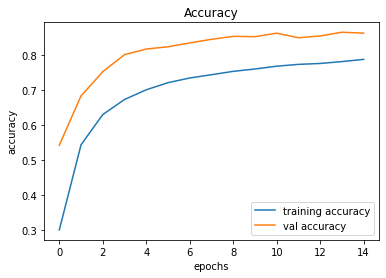

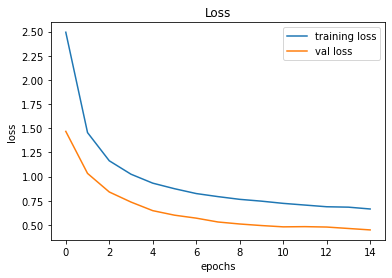

In [ ]:
# 모델의 정확도와 loss 변화 
plt.figure(0)
plt.plot(history_3.history['accuracy'], label='training accuracy')
plt.plot(history_3.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history_3.history['loss'], label='training loss')
plt.plot(history_3.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 테스트셋(컬러) 정확도
pred_test = model_3.predict_classes(X_test_color_low)
print(accuracy_score(y_test_low, pred_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8582739509105305


**흑백 이미지**

    validation 예측 정확도 :  0.9473
    test 예측 정확도 :  0.9519

**컬러 이미지 (낮은 해상도)**

    validation 예측 정확도 :  0.8618
    test 예측 정확도 :  0.8583

같은 화소수의 카메라일지라도, 컬러 카메라로 찍은 이미지의 해상도는 흑백 카메라로 찍은 것의 1/3 입니다. 그 이유는 컬러 카메라의 Bayer 필터(=RGB 필터) 때문입니다. 컬러 카메라는 흑백 센서 위에 Bayer 필터를 부착하는 방식으로 만들어 지는데, 각 색깔의 필터들은 색깔을 표현하기위해 화소수를 나눠가집니다. (Red은 1/4, Green는 1/2, Blue는 1/4씩). 그래서, 흑백카메라로 찍혔더라면 화소수를 나눠가질 필요없이 카메라의 화소수에따라 해상도를 100% 가질 수 있지만, 컬러 카메라의 경우엔 해상도를 포기해야합니다. 

그래서, 위처럼 컬러 이미지의 해상도를 흑백 이미지의 1/3로 낮추고 모델 학습과 예측을 진행했더니 현저하게 정확도가 떨어지는 것을 볼 수 있었습니다. 

이제, 흑백 이미지가 컬러 이미지보다 더 나은 성능, 속도, 해상도를 가진다는 것을 알게되었으니, 아래에선 모델 개선을 위한 작업을 진행하겠습니다.

# Scaling

<p align = 'center'>
<img width="928" alt="스크린샷 2021-03-09 오후 8 19 09" src="https://user-images.githubusercontent.com/61172021/110463009-bae79400-8114-11eb-87e5-dcfac03f5b35.png">
</p>


2020년 9월에 발표된 논문 "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks" 에서는 CNN 모델의 성능을 올리는 방법으로 4가지 Scaling 방법을 소개했습니다. 그 중 첫번째인 Width Scaling 은 위 그림과 같이 기본 모델의 filter 개수를 늘리는 방법으로, MobileNet, ShuffleNet 등이 Width Scaling 방법을 적용한 모델입니다. 두번째 방법인 Depth Scaling 은 layer 의 개수를 늘리는 방법으로, 대표적으로 ResNet 이 Depth Scaling 방법을 적용한 모델입니다. 세번째로 Resolution Scaling 이란 심플하게 input 이미지의 해상도를 높이는 방법입니다. 마지막으로, Compound Scaling 이란 앞서 설명한 3가지 방법을 한번에 모두 사용하는 방법입니다. 

이 방법들을 어떻게 사용하는지에 대한 명확한 가이드라인은 존재하지 않으므로, 변화를 주는 요소를 제외한 나머지 값들은 고정해두고 변화를 관찰해야합니다. 이미 Resolution Scaling 의 결과는 이미 위에서 고화질과 저화질의 비교로 확인했기 때문에, 아래에선 Width Scaling 과 Depth Scaling 의 결과를 보고, 그 후 3가지 방법을 합친 Compound Scaling 을 적용해보겠습니다.

### Width Scaling

In [ ]:
# 데이터 셋 
print("학습 셋 : ", X_train_gray.shape, y_train_gray.shape)
print("검증 셋 : ", X_val_gray.shape, y_val_gray.shape)
print("테스트 셋 : ", X_test_gray.shape, y_test_gray.shape)

학습 셋 :  (39209, 54, 54, 1) (39209, 43)
검증 셋 :  (6315, 54, 54, 1) (6315, 43)
테스트 셋 :  (6315, 54, 54, 1) (6315,)


In [ ]:
# 모델 만들기
model_4 = Sequential()
model_4.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=X_train_gray.shape[1:]))
model_4.add(MaxPool2D(pool_size=(2, 2)))
model_4.add(Dropout(rate=0.25))
model_4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_4.add(MaxPool2D(pool_size=(2, 2)))
model_4.add(Dropout(rate=0.25))
model_4.add(Flatten())
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(rate=0.5))
model_4.add(Dense(43, activation='softmax'))
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 52, 52, 16)        160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 26, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)             

In [ ]:
# 모델 학습
%time history_4 = model_4.fit(X_train_gray, y_train_gray, batch_size=32, epochs=15, validation_data=(X_val_gray, y_val_gray))

Epoch 1/15
1226/1226 [==============================] - 21s 4ms/step - loss: 2.2376 - accuracy: 0.4045 - val_loss: 0.5231 - val_accuracy: 0.8500
Epoch 2/15
1226/1226 [==============================] - 4s 3ms/step - loss: 0.5202 - accuracy: 0.8414 - val_loss: 0.3638 - val_accuracy: 0.9113
Epoch 3/15
1226/1226 [==============================] - 4s 4ms/step - loss: 0.3460 - accuracy: 0.8955 - val_loss: 0.3019 - val_accuracy: 0.9238
Epoch 4/15
1226/1226 [==============================] - 4s 4ms/step - loss: 0.2580 - accuracy: 0.9215 - val_loss: 0.2911 - val_accuracy: 0.9221
Epoch 5/15
1226/1226 [==============================] - 4s 4ms/step - loss: 0.2183 - accuracy: 0.9289 - val_loss: 0.2876 - val_accuracy: 0.9310
Epoch 6/15
1226/1226 [==============================] - 4s 4ms/step - loss: 0.1797 - accuracy: 0.9445 - val_loss: 0.2258 - val_accuracy: 0.9443
Epoch 7/15
1226/1226 [==============================] - 4s 4ms/step - loss: 0.1564 - accuracy: 0.9510 - val_loss: 0.2034 - val_accuracy

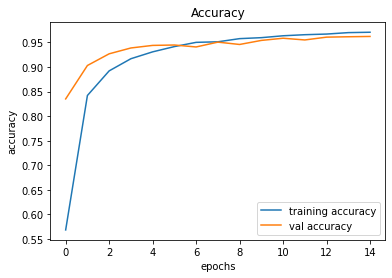

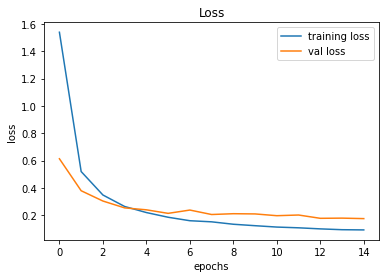

In [ ]:
# 모델의 정확도와 loss 변화 
plt.figure(0)
plt.plot(history_4.history['accuracy'], label='training accuracy')
plt.plot(history_4.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history_4.history['loss'], label='training loss')
plt.plot(history_4.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 테스트셋(흑백) 정확도
%time pred_test_gray = model_4.predict_classes(X_test_gray)
print(accuracy_score(y_test_gray, pred_test_gray))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CPU times: user 462 ms, sys: 65.4 ms, total: 527 ms
Wall time: 365 ms
0.9613618368962787


Width Scaling 전

    validation 예측 정확도 :  0.9473
    test 예측 정확도 :  0.9519

Width Scaling 후

    validation 예측 정확도 :  0.9604
    test 예측 정확도 :  0.9614


### Depth Scaling

In [ ]:
# 데이터 셋 
print("학습 셋 : ", X_train_gray.shape, y_train_gray.shape)
print("검증 셋 : ", X_val_gray.shape, y_val_gray.shape)
print("테스트 셋 : ", X_test_gray.shape, y_test_gray.shape)

학습 셋 :  (39209, 54, 54, 1) (39209, 43)
검증 셋 :  (6315, 54, 54, 1) (6315, 43)
테스트 셋 :  (6315, 54, 54, 1) (6315,)


In [ ]:
# 모델 만들기
model_5 = Sequential()
model_5.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=X_train_gray.shape[1:]))
model_5.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu'))
model_5.add(MaxPool2D(pool_size=(2, 2)))
model_5.add(Dropout(rate=0.25))
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_5.add(MaxPool2D(pool_size=(2, 2)))
model_5.add(Dropout(rate=0.25))
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_5.add(MaxPool2D(pool_size=(2, 2)))
model_5.add(Dropout(rate=0.25))
model_5.add(Flatten())
model_5.add(Dense(256, activation='relu'))
model_5.add(Dropout(rate=0.5))
model_5.add(Dense(43, activation='softmax'))
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 52, 52, 8)         80        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 8)         0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 23, 23, 16)        1168      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 16)        2320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 10, 10, 16)       

In [ ]:
# 모델 학습
%time history_5 = model_5.fit(X_train_gray, y_train_gray, batch_size=32, epochs=15, validation_data=(X_val_gray, y_val_gray))

Epoch 1/15
1226/1226 [==============================] - 6s 5ms/step - loss: 2.6609 - accuracy: 0.2802 - val_loss: 0.5158 - val_accuracy: 0.8513
Epoch 2/15
1226/1226 [==============================] - 6s 5ms/step - loss: 0.5369 - accuracy: 0.8300 - val_loss: 0.2601 - val_accuracy: 0.9292
Epoch 3/15
1226/1226 [==============================] - 6s 5ms/step - loss: 0.3272 - accuracy: 0.8961 - val_loss: 0.3218 - val_accuracy: 0.9243
Epoch 4/15
1226/1226 [==============================] - 6s 5ms/step - loss: 0.2685 - accuracy: 0.9126 - val_loss: 0.1902 - val_accuracy: 0.9503
Epoch 5/15
1226/1226 [==============================] - 6s 5ms/step - loss: 0.2216 - accuracy: 0.9289 - val_loss: 0.1684 - val_accuracy: 0.9584
Epoch 6/15
1226/1226 [==============================] - 6s 5ms/step - loss: 0.1818 - accuracy: 0.9432 - val_loss: 0.1907 - val_accuracy: 0.9549
Epoch 7/15
1226/1226 [==============================] - 6s 5ms/step - loss: 0.1690 - accuracy: 0.9482 - val_loss: 0.1554 - val_accuracy:

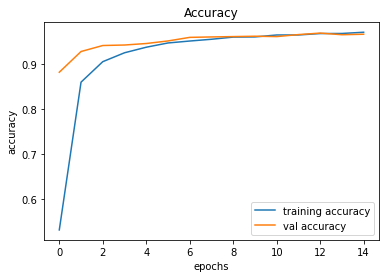

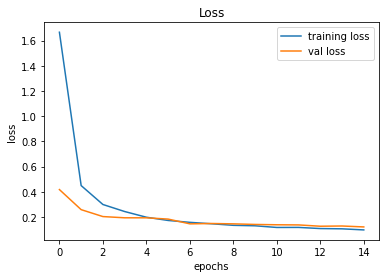

In [ ]:
# 모델의 정확도와 loss 변화  
plt.figure(0)
plt.plot(history_5.history['accuracy'], label='training accuracy')
plt.plot(history_5.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history_5.history['loss'], label='training loss')
plt.plot(history_5.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 테스트셋(흑백) 정확도
%time pred_test_gray = model_5.predict_classes(X_test_gray)
print(accuracy_score(y_test_gray, pred_test_gray))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CPU times: user 506 ms, sys: 49 ms, total: 555 ms
Wall time: 394 ms
0.9686460807600951


Depth Scaling 전

    validation 예측 정확도 :  0.9473
    test 예측 정확도 :  0.9519

Depth Scaling 후

    validation 예측 정확도 :  0.9683
    test 예측 정확도 :  0.9686

### Compound Scaling (Width Scaling +Depth Scaling)

In [ ]:
# 데이터 셋 
print("학습 셋 : ", X_train_gray.shape, y_train_gray.shape)
print("검증 셋 : ", X_val_gray.shape, y_val_gray.shape)
print("테스트 셋 : ", X_test_gray.shape, y_test_gray.shape)

학습 셋 :  (39209, 54, 54, 1) (39209, 43)
검증 셋 :  (6315, 54, 54, 1) (6315, 43)
테스트 셋 :  (6315, 54, 54, 1) (6315,)


In [ ]:
# 모델 만들기
model_6 = Sequential()
model_6.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=X_train_gray.shape[1:]))
model_6.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model_6.add(MaxPool2D(pool_size=(2, 2)))
model_6.add(Dropout(rate=0.25))
model_6.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_6.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_6.add(MaxPool2D(pool_size=(2, 2)))
model_6.add(Dropout(rate=0.25))
model_6.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_6.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_6.add(MaxPool2D(pool_size=(2, 2)))
model_6.add(Dropout(rate=0.25))
model_6.add(Flatten())
model_6.add(Dense(256, activation='relu'))
model_6.add(Dropout(rate=0.5))
model_6.add(Dense(43, activation='softmax'))
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_6.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 52, 52, 16)        160       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 50, 50, 16)        2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 23, 23, 32)        4640      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 10, 10, 32)       

In [ ]:
# 모델 학습
%time history_6 = model_6.fit(X_train_gray, y_train_gray, batch_size=32, epochs=15, validation_data=(X_val_gray, y_val_gray))

Epoch 1/15
1226/1226 [==============================] - 7s 5ms/step - loss: 2.3202 - accuracy: 0.3707 - val_loss: 0.3186 - val_accuracy: 0.9089
Epoch 2/15
1226/1226 [==============================] - 6s 5ms/step - loss: 0.3266 - accuracy: 0.8993 - val_loss: 0.1915 - val_accuracy: 0.9438
Epoch 3/15
1226/1226 [==============================] - 6s 5ms/step - loss: 0.1844 - accuracy: 0.9431 - val_loss: 0.1513 - val_accuracy: 0.9558
Epoch 4/15
1226/1226 [==============================] - 6s 5ms/step - loss: 0.1304 - accuracy: 0.9600 - val_loss: 0.1379 - val_accuracy: 0.9591
Epoch 5/15
1226/1226 [==============================] - 6s 5ms/step - loss: 0.1104 - accuracy: 0.9660 - val_loss: 0.1287 - val_accuracy: 0.9639
Epoch 6/15
1226/1226 [==============================] - 6s 5ms/step - loss: 0.0900 - accuracy: 0.9725 - val_loss: 0.1681 - val_accuracy: 0.9590
Epoch 7/15
1226/1226 [==============================] - 6s 5ms/step - loss: 0.0828 - accuracy: 0.9755 - val_loss: 0.1091 - val_accuracy:

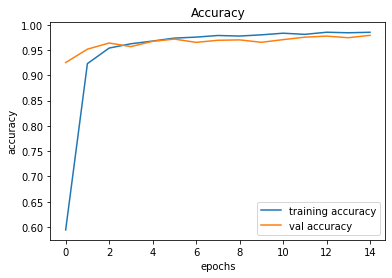

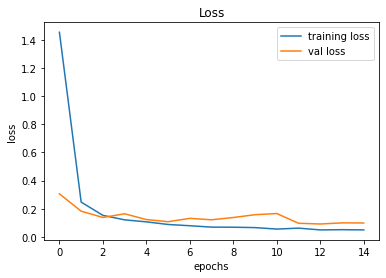

In [ ]:
# 모델의 정확도와 loss 변화  
plt.figure(0)
plt.plot(history_6.history['accuracy'], label='training accuracy')
plt.plot(history_6.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history_6.history['loss'], label='training loss')
plt.plot(history_6.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 테스트셋(흑백) 정확도
%time pred_test_gray = model_6.predict_classes(X_test_gray)
print(accuracy_score(y_test_gray, pred_test_gray))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CPU times: user 513 ms, sys: 56.9 ms, total: 570 ms
Wall time: 398 ms
0.9752969121140143


기본 모델

    validation 예측 정확도 :  0.9473
    test 예측 정확도 :  0.9519

Width Scaling 만 적용 했을 때

    validation 예측 정확도 :  0.9604
    test 예측 정확도 :  0.9614

Depth Scaling 만 적용 했을 때

    validation 예측 정확도 :  0.9683
    test 예측 정확도 :  0.9686

Compound Scaling (Width Scaling +Depth Scaling)

    validation 예측 정확도 :  0.9743
    test 예측 정확도 :  0.9753

=> Compound Scaling 의 결과가 가장 좋습니다. 이 모델을 가지고 Data Augmentation 을 적용해 모델 개선의 여지가 있는지 보겠습니다.

# Data Augmentation

처음 Data Augmentation 을 적용할 때 오히려 성능이 내려가는 상황을 겪었습니다. 왜 그런지 곰곰히 생각해보니 상하 반전, 좌우 반전같은 변화를 사용해서 그랬던 것 같습니다. 실제 표지판은 거꾸로 되어있을리가 없으니, 상하/좌우 반전같은 변화를 주어 학습하면 성능이 내려가는 결과를 낳게됩니다. 그리고, rotation_range(회전) 도 조금만(10도 정도만) 사용해야 합니다. 90도로 꺾여있는 표지판은 없으니까요!

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
)

In [ ]:
datagen.fit(X_train_gray)

In [ ]:
# 모델 만들기
model_7 = Sequential()
model_7.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=X_train_gray.shape[1:]))
model_7.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model_7.add(MaxPool2D(pool_size=(2, 2)))
model_7.add(Dropout(rate=0.25))
model_7.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_7.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_7.add(MaxPool2D(pool_size=(2, 2)))
model_7.add(Dropout(rate=0.25))
model_7.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_7.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_7.add(MaxPool2D(pool_size=(2, 2)))
model_7.add(Dropout(rate=0.25))
model_7.add(Flatten())
model_7.add(Dense(256, activation='relu'))
model_7.add(Dropout(rate=0.5))
model_7.add(Dense(43, activation='softmax'))
model_7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델 학습
%time history_7 = model_7.fit(datagen.flow(X_train_gray, y_train_gray, batch_size=32), steps_per_epoch=len(X_train_gray) / 32, epochs=15, validation_data=(X_val_gray, y_val_gray))

Epoch 1/15
1225/1225 [==============================] - 25s 19ms/step - loss: 2.8960 - accuracy: 0.2133 - val_loss: 0.3529 - val_accuracy: 0.8893
Epoch 2/15
1225/1225 [==============================] - 23s 19ms/step - loss: 0.6877 - accuracy: 0.7851 - val_loss: 0.1840 - val_accuracy: 0.9427
Epoch 3/15
1225/1225 [==============================] - 24s 19ms/step - loss: 0.3682 - accuracy: 0.8864 - val_loss: 0.1193 - val_accuracy: 0.9644
Epoch 4/15
1225/1225 [==============================] - 23s 19ms/step - loss: 0.2626 - accuracy: 0.9162 - val_loss: 0.1047 - val_accuracy: 0.9704
Epoch 5/15
1225/1225 [==============================] - 24s 19ms/step - loss: 0.2069 - accuracy: 0.9341 - val_loss: 0.0737 - val_accuracy: 0.9789
Epoch 6/15
1225/1225 [==============================] - 24s 19ms/step - loss: 0.1725 - accuracy: 0.9475 - val_loss: 0.0844 - val_accuracy: 0.9739
Epoch 7/15
1225/1225 [==============================] - 23s 19ms/step - loss: 0.1569 - accuracy: 0.9526 - val_loss: 0.0695 -

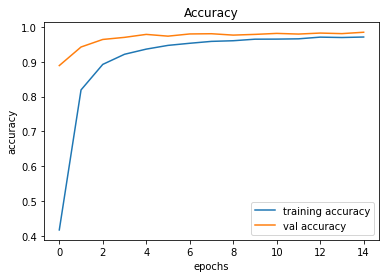

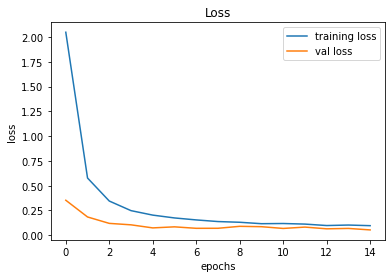

In [ ]:
# 모델의 정확도와 loss 변화  
plt.figure(0)
plt.plot(history_7.history['accuracy'], label='training accuracy')
plt.plot(history_7.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history_7.history['loss'], label='training loss')
plt.plot(history_7.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 테스트셋(흑백) 정확도
%time pred_test_gray = model_7.predict_classes(X_test_gray)
print(accuracy_score(y_test_gray, pred_test_gray))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CPU times: user 639 ms, sys: 75.4 ms, total: 715 ms
Wall time: 521 ms
0.9862232779097387


Data Augmentation 을 사용하니 데스트셋에 대한 정확도가 98퍼센트 이상이 나옵니다!

Data Augmentation 전

    validation 예측 정확도 :  0.9743
    test 예측 정확도 :  0.9753

Data Augmentation 후

    validation 예측 정확도 :  0.9851
    test 예측 정확도 :  0.9862

# Cross Validation

- 모든 데이터셋을 훈련에 사용할 수 있다는 장점이 있다.

- 훈련, 평가 시 사용되는 데이터의 편중을 줄일 수 있고, 조금 더 일반화된 모델을 만들 수 있다. 

In [ ]:
# 데이터 셋 
print("학습 셋 : ", X_train_gray.shape, y_train_gray.shape)
print("검증 셋 : ", X_val_gray.shape, y_val_gray.shape)
print("테스트 셋 : ", X_test_gray.shape, y_test_gray.shape)

학습 셋 :  (39209, 54, 54, 1) (39209, 43)
검증 셋 :  (6315, 54, 54, 1) (6315, 43)
테스트 셋 :  (6315, 54, 54, 1) (6315,)


In [ ]:
# 모델 만들기
model_8 = Sequential()
model_8.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=X_train_gray.shape[1:]))
model_8.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model_8.add(MaxPool2D(pool_size=(2, 2)))
model_8.add(Dropout(rate=0.25))
model_8.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_8.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_8.add(MaxPool2D(pool_size=(2, 2)))
model_8.add(Dropout(rate=0.25))
model_8.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_8.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_8.add(MaxPool2D(pool_size=(2, 2)))
model_8.add(Dropout(rate=0.25))
model_8.add(Flatten())
model_8.add(Dense(256, activation='relu'))
model_8.add(Dropout(rate=0.5))
model_8.add(Dense(43, activation='softmax'))
model_8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 5번 진행합니다.
kfold = KFold(n_splits=5, shuffle=True, random_state = 1)

In [ ]:
# 모델 학습
for train_index, val_index in kfold.split(X_train_gray):

    X_train_fold, X_val_fold = X_train_gray[train_index], X_train_gray[val_index]
    y_train_fold, y_val_fold = y_train_gray[train_index], y_train_gray[val_index]

    %time history_8 = model_8.fit(datagen.flow(X_train_fold, y_train_fold, batch_size=32), steps_per_epoch=len(X_train_fold) / 32, epochs=15, validation_data=(X_val_fold, y_val_fold))

Epoch 1/15
980/980 [==============================] - 20s 20ms/step - loss: 3.0050 - accuracy: 0.1872 - val_loss: 0.3317 - val_accuracy: 0.9175
Epoch 2/15
980/980 [==============================] - 19s 19ms/step - loss: 0.7785 - accuracy: 0.7610 - val_loss: 0.1025 - val_accuracy: 0.9740
Epoch 3/15
980/980 [==============================] - 19s 19ms/step - loss: 0.4165 - accuracy: 0.8699 - val_loss: 0.0556 - val_accuracy: 0.9843
Epoch 4/15
980/980 [==============================] - 19s 19ms/step - loss: 0.2958 - accuracy: 0.9104 - val_loss: 0.0323 - val_accuracy: 0.9907
Epoch 5/15
980/980 [==============================] - 19s 19ms/step - loss: 0.2300 - accuracy: 0.9310 - val_loss: 0.0241 - val_accuracy: 0.9926
Epoch 6/15
980/980 [==============================] - 19s 19ms/step - loss: 0.1984 - accuracy: 0.9397 - val_loss: 0.0234 - val_accuracy: 0.9934
Epoch 7/15
980/980 [==============================] - 19s 19ms/step - loss: 0.1797 - accuracy: 0.9471 - val_loss: 0.0196 - val_accuracy:

In [ ]:
%time pred_test_gray = model_8.predict_classes(X_test_gray)
print(accuracy_score(y_test_gray, pred_test_gray))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CPU times: user 651 ms, sys: 83.2 ms, total: 734 ms
Wall time: 532 ms
0.9874901029295329


Cross Validation 전

    validation 예측 정확도 :  0.9851
    test 예측 정확도 :  0.9862

Cross Validation 후

    validation 예측 정확도 :  0.9973
    test 예측 정확도 :  0.9875

# 모델 저장 및 requirements.txt 만들기

In [ ]:
# 모델 저장

model_8.save('final_model')

INFO:tensorflow:Assets written to: final_model/assets


In [ ]:
# 저장된 모델 불러오기

model_final = load_model('final_model')

In [ ]:
# 모델 평가

model_final.evaluate(X_val_gray, y_val_gray)

198/198 [==============================] - 1s 3ms/step - loss: 0.0662 - accuracy: 0.9865


[0.06622347980737686, 0.9865399599075317]

In [ ]:
# requirements.txt 만들기
pip freeze > requirements.txt